In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from livelossplot import PlotLossesKerasTF

from tensorflow.keras import backend as K
from tensorflow.keras import utils


In [2]:
np.random.seed(42)

In [3]:
DATA = "emotion_dataset"
DATA_PATH = f"{DATA}/"
BASE_PATH = "/home/nirmit/Desktop/project/"
TOP_EMOTIONS = ["Happy", "Neutral", "Sad", "Surprise", "Angry"]
TRAIN_SIZE = 0.88
INPUT_SHAPE = (48,48,1)
NUM_CLASSES = len(TOP_EMOTIONS)

In [4]:
class_count = {}
for dir_ in os.listdir(DATA_PATH):
    if not dir_.isupper():
        os.rename(DATA_PATH+dir_, DATA_PATH+dir_.title())
        dir_ = dir_.title()

    count = 0
    for f in os.listdir(DATA_PATH + dir_ + "/"):
        count += 1

    class_count[dir_] = count
    print(f"{dir_} has {count} number of images")

total_images = sum(class_count.values())
print(f"\ntotal images are {total_images}")

Angry has 9886 number of images
Disgust has 4542 number of images
Fear has 9218 number of images
Happy has 18406 number of images
Neutral has 11163 number of images
Sad has 12060 number of images
Surprise has 9081 number of images

total images are 74356


In [5]:
for k,v in class_count.items():
    if not k in TOP_EMOTIONS:
        total_images -= v
total_images

60596

In [6]:
img_arr = np.empty(shape=(total_images, *INPUT_SHAPE))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
label = 0
for dir_ in os.listdir(DATA_PATH):

    if dir_ in TOP_EMOTIONS:
        label_to_text[label] = dir_
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img_arr[i] = np.expand_dims(cv2.imread(DATA_PATH + dir_ + "/" + f, 0), axis=2)
            img_label[i] = label
            i += 1

        print(f"loaded {dir_} images to numpy arrays...")
        label += 1

img_label = utils.to_categorical(img_label)
img_arr.shape, img_label.shape
label_to_text

loaded Angry images to numpy arrays...
loaded Happy images to numpy arrays...
loaded Neutral images to numpy arrays...
loaded Sad images to numpy arrays...
loaded Surprise images to numpy arrays...


{0: 'Angry', 1: 'Happy', 2: 'Neutral', 3: 'Sad', 4: 'Surprise'}

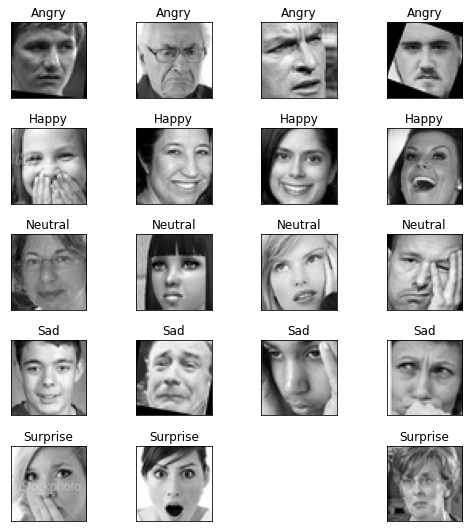

In [7]:
num_emotions = len(TOP_EMOTIONS)
fig = pyplot.figure(1, (num_emotions*1.5, num_emotions*1.5))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:,k]==1)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(num_emotions,4,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [8]:
img_arr = img_arr / 255.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=TRAIN_SIZE, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((53324, 48, 48, 1), (7272, 48, 48, 1), (53324, 5), (7272, 5))

In [10]:
def build_net(optims, input_shape, num_classes, show_summary=True):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(input_shape),
            activation='elu',
            padding='same',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optims,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [11]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

In [13]:
batch_size = 32 #batch size of 32 performs the best.

epochs = 65

optims = [
  optimizers.Nadam(
      learning_rate=0.001,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      name='Nadam'),
    
  optimizers.Adam(0.001),
]

In [15]:
model = build_net(optims[1], INPUT_SHAPE, NUM_CLASSES, show_summary=False ) 

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

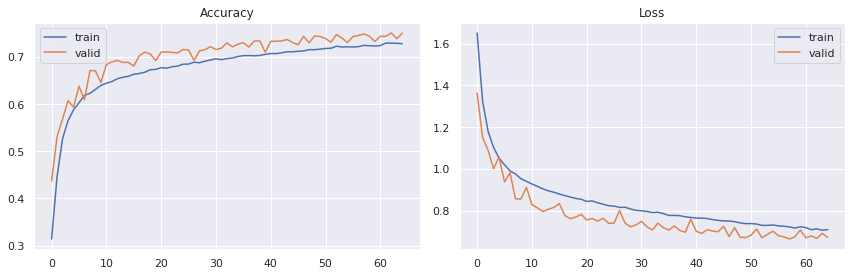

In [16]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

In [22]:
model.save_weights("model_7.h5")
model_json = model.to_json()
with open("model_7.json", "w") as json_file:
    json_file.write(model_json)

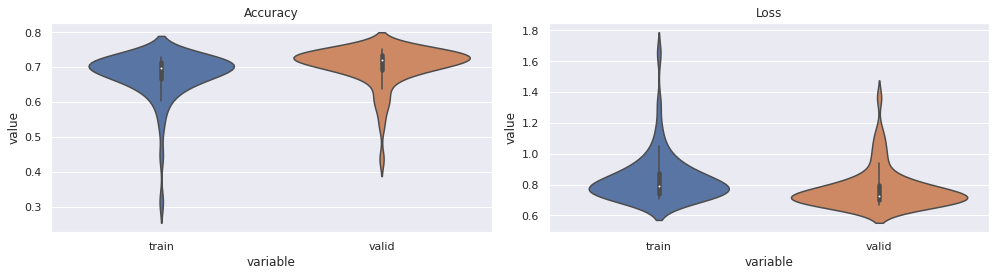

In [23]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

test accuracy: 75.0413 %


              precision    recall  f1-score   support

           0       0.81      0.68      0.74      1186
           1       0.89      0.93      0.91      2209
           2       0.66      0.79      0.72      1340
           3       0.59      0.75      0.66      1447
           4       0.86      0.41      0.55      1090

    accuracy                           0.75      7272
   macro avg       0.76      0.71      0.72      7272
weighted avg       0.77      0.75      0.74      7272



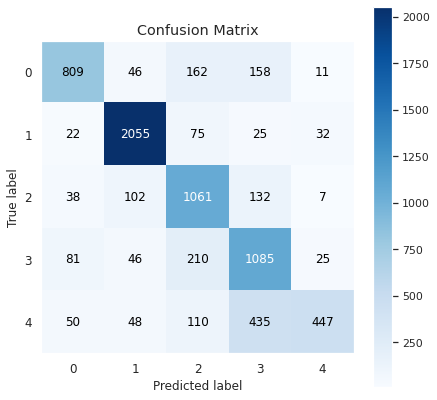

In [27]:
yhat_valid = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)
scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")
test_accu = np.sum(ytest_ == yhat_valid) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_valid))

In [1]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        pyplot.tight_layout()

NameError: name 'np' is not defined